In [1]:
import pandas as pd
import numpy as np
import spacy
import os
from pathlib import Path
from importlib import reload

In [4]:
import source.prepare_data as prd
import source.dataset as dat
import source.multi_layer_perceptron as mlp
import source.table as tb

In [5]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)

<module 'source.table' from 'C:\\DL2\\source\\table.py'>

In [6]:
"""
1) Preprocessing
"""
# load models and dataset
df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/train.csv", nrows=1000)
nlp = spacy.load("en_core_web_sm")

# prepare dataset
df = prd.prepare_df(df, nlp)

# create dataset out of cleaned columns
dataset = dat.Text_Dataset(df, col_text="clean_text_str", col_label="sentiment", args={"max_features":5000})
dataset.split_dataset()


In [7]:
df

,sentiment,clean_text,clean_text_str,text
0,1,"[love, you, toooooo, TG, LOL, Gngb]",love you toooooo TG LOL Gngb,@tonigirl14 love you toooooo ! ! TG LOL Gngb
1,0,"[I, tell, myself, do, click, on, this, link, b...",I tell myself do click on this link but I just...,@jun6lee I told myself : Do n't click on this ...
2,0,"[the, man, who, render, his, voice, to, Mickey...",the man who render his voice to Mickey Mouse e...,The man who rendered his voice to Mickey Mouse...
3,1,"[I, think, red, would, be, nice, or, maybe, yo...",I think red would be nice or maybe you could d...,@Shontelle_Layne I think red would be nice . ...
4,0,"[I, guess, one, of, her, tweet, say, she, be, ...",I guess one of her tweet say she be confused,@Silverlines - I guess . 'Cause one of her twe...
...,...,...,...,...
995,0,"[do, feel, bad, cause, I, can, either]",do feel bad cause I can either,@songbookbaby do n't feel bad cause I ca n't e...
996,0,"[luv, your, new, pic, u, play, guitar, too, co...",luv your new pic u play guitar too come on sto...,@aznchicken4795 luv your new pic ... u play gu...
997,1,"[hey, use, my, name, on, here, now, huh, now, ...",hey use my name on here now huh now how do I h...,@Monkeylover35 Hey using my name on here now h...
998,0,"[good, morning, twitter, OMFG, the, sun, be, r...",good morning twitter OMFG the sun be really we...,good morning twitters OMFG the sun is really...


In [8]:
"""
2) Accuracy analysis for MLP model. We will compare the workflow of MLP by using TD-IDF encoding and BOW encoding

2.1) TD-IDF encoding
"""
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = dataset.get_encodings(tfidf=True)

mlp_tdidf_params = mlp.find_best_mlp(X_train=X_train_TF,
                                      Y_train=Y_train_TF,
                                      X_test=X_test_TF,
                                      Y_test=Y_test_TF,
                                      n_trials = 7)

[I 2025-06-12 21:14:01,442] A new study created in memory with name: mlp_optimization


[I 2025-06-12 21:14:03,716] Trial 0 finished with values: [0.6606584191322327, 0.574999988079071] and parameters: {'epochs': 122, 'learning_rate': 0.09436195626192197, 'units': 2}.
[I 2025-06-12 21:14:05,516] Trial 1 finished with values: [0.6404473185539246, 0.6150000095367432] and parameters: {'epochs': 119, 'learning_rate': 0.1164781980488819, 'units': 5}.
[I 2025-06-12 21:14:07,497] Trial 2 finished with values: [0.6079900860786438, 0.6850000023841858] and parameters: {'epochs': 135, 'learning_rate': 0.2941274212297077, 'units': 8}.
[I 2025-06-12 21:14:09,851] Trial 3 finished with values: [0.6269921660423279, 0.6899999976158142] and parameters: {'epochs': 166, 'learning_rate': 0.2535758016129473, 'units': 9}.
[I 2025-06-12 21:14:12,148] Trial 4 finished with values: [0.575019359588623, 0.6899999976158142] and parameters: {'epochs': 154, 'learning_rate': 0.22649071815097996, 'units': 10}.
[I 2025-06-12 21:14:14,240] Trial 5 finished with values: [0.5587507486343384, 0.6949999928474


Best params:
    accuracy: 0.695
    loss function: 0.5588
    number of epochs: 149
    learning rate: 0.2043
    units: 5



In [9]:
mlp_tdidf_params

number                                                            5
loss                                                       0.558751
accuracy                                                      0.695
datetime_start                           2025-06-12 21:14:12.149221
datetime_complete                        2025-06-12 21:14:14.239277
duration                                     0 days 00:00:02.090056
params_epochs                                                   149
params_learning_rate                                       0.204295
params_units                                                      5
system_attrs_NSGAIISampler:generation                             0
state                                                      COMPLETE
Name: 0, dtype: object

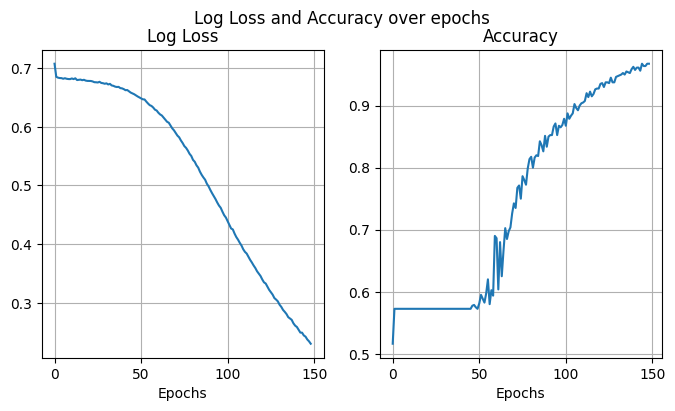

In [10]:
mlp_tdidf = mlp.Feedforward_Model(X_train_TF, Y_train_TF, units=mlp_tdidf_params['params_units'])
mlp_tdidf.train(LR=mlp_tdidf_params['params_learning_rate'], epochs=mlp_tdidf_params['params_epochs'])
mlp_tdidf.plot_loss_accuracy()

In [11]:
"""
2.2) BOW encoding
"""
X_train_BOW, X_test_BOW, Y_train_BOW, Y_test_BOW = dataset.get_encodings(tfidf=False)

mlp_bow_params = mlp.find_best_mlp(X_train=X_train_BOW,
                                      Y_train=Y_train_BOW,
                                      X_test=X_test_BOW,
                                      Y_test=Y_test_BOW,
                                      n_trials = 3)

[I 2025-06-12 21:16:43,726] A new study created in memory with name: mlp_optimization
[I 2025-06-12 21:16:45,915] Trial 0 finished with values: [0.8199965953826904, 0.7049999833106995] and parameters: {'epochs': 131, 'learning_rate': 0.18497197198369555, 'units': 7}.
[I 2025-06-12 21:16:48,459] Trial 1 finished with values: [0.913618803024292, 0.7049999833106995] and parameters: {'epochs': 161, 'learning_rate': 0.19381957094601104, 'units': 6}.
[I 2025-06-12 21:16:50,933] Trial 2 finished with values: [0.7890218496322632, 0.699999988079071] and parameters: {'epochs': 154, 'learning_rate': 0.15482465282853236, 'units': 6}.



Best params:
    accuracy: 0.705
    loss function: 0.9136
    number of epochs: 161
    learning rate: 0.1938
    units: 6



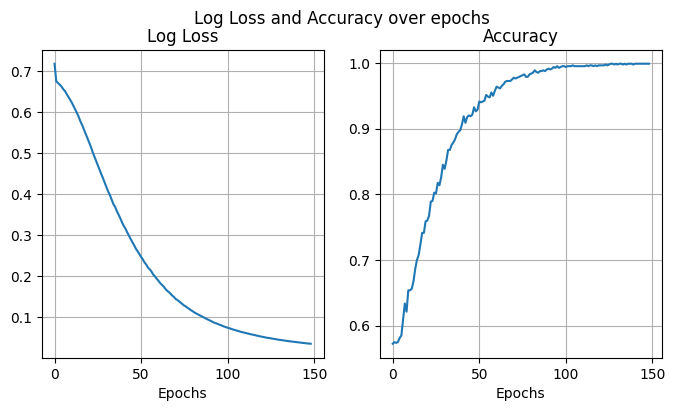

In [13]:
mlp_bow = mlp.Feedforward_Model(X_train_BOW, Y_train_BOW, units=mlp_tdidf_params['params_units'])
mlp_bow.train(LR=mlp_tdidf_params['params_learning_rate'], epochs=mlp_tdidf_params['params_epochs'])
mlp_bow.plot_loss_accuracy()